<a href="https://colab.research.google.com/github/samuelmap1/Projetos/blob/main/Banking_Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introdução

O fenômeno do churn, ou a saída de clientes, é uma preocupação crítica para instituições financeiras. Neste projeto, abordamos a tarefa de prever o churn em um banco, utilizando técnicas avançadas de ciência de dados. A retenção de clientes é essencial para o sucesso a longo prazo da instituição, e a capacidade de antecipar a probabilidade de um cliente deixar o banco oferece oportunidades para estratégias criativas e personalizadas.

### Importando bibliotecas

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
import category_encoders as ce
from sklearn.compose import ColumnTransformer
from sklearn.metrics import average_precision_score, confusion_matrix, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

### Funções criadas

In [ ]:
def modelo(classificador, X_train, y_train, X_test, y_test):

    classificador.fit(X_train, y_train)
    y_pred = classificador.predict(X_test)
    fold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 0)
    score = cross_val_score(classificador, X_train, y_train, cv = fold, scoring = 'roc_auc', n_jobs = -1).mean()
    print(f"Score Cross Validation: {score:.2%}")
    print(f"Average Precision: {average_precision_score(y_test, y_pred):.2%}")
    print(f"Precision Score: {precision_score(y_test, y_pred):.2%}")
    print(f"Recall Score: {recall_score(y_test, y_pred):.2%}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.2%}")
    print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred):.2%}")

In [ ]:
def preprocessor(X_train, y_train, X_test, scaler):
    # Preenchimento dos valores ausentes para características numéricas com a mediana
    num_imputer = SimpleImputer(strategy='median')
    cat_imputer = SimpleImputer(strategy='most_frequent')
    aux_num_train = pd.DataFrame(num_imputer.fit_transform(X_train[numerical_features]), columns=numerical_features)
    aux_cat_train = pd.DataFrame(cat_imputer.fit_transform(X_train[categorical_features]), columns=categorical_features)
    aux_num_test = pd.DataFrame(num_imputer.transform(X_test[numerical_features]), columns=numerical_features)
    aux_cat_test = pd.DataFrame(cat_imputer.transform(X_test[categorical_features]), columns=categorical_features)

    X_train = pd.concat((aux_num_train, aux_cat_train), axis=1)
    X_test = pd.concat((aux_num_test, aux_cat_test), axis=1)

    # Encoding
    y_train = y_train.reset_index()["Exited"]
    cat_train = pd.DataFrame(cat_transformer.fit_transform(X_train, y_train), columns=np.concatenate((categorical_features_binary, categorical_features_non_binary)))
    cat_test = pd.DataFrame(cat_transformer.transform(X_test), columns=np.concatenate((categorical_features_binary, categorical_features_non_binary)))
    X_train = pd.concat((X_train[numerical_features], cat_train), axis=1)
    X_test = pd.concat((X_test[numerical_features], cat_test), axis=1)

    # Normalizando os dados
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test

In [ ]:
def matriz_confusao(classificador, X_test, y_test):

    cm = confusion_matrix(y_test, classificador.predict(X_test))
    nomes = ['Verdadeiro Neg.','Falso Pos.','Falso Neg.','Verdadeiro Pos.']
    counts = [value for value in cm.flatten()]
    porcentagens = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(nomes, counts, porcentagens)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (16, 9))
    sns.heatmap(cm, annot = labels, cmap = 'Blues', fmt ='')
    plt.show();

#### Leitura dos dados

In [ ]:
df = pd.read_csv("Churn_Modelling.csv")

In [ ]:
df.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2,134603.88,1,1,1,71725.73,0


### Feature engineering

In [ ]:
df['Salary_Credit_Score_Ratio'] = df['EstimatedSalary']/df['CreditScore']
df['Tenure_Products_Ratio'] = df['Tenure']/df['NumOfProducts']

In [ ]:
df.corr()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Salary_Credit_Score_Ratio,Tenure_Products_Ratio
RowNumber,1.000000,0.004202,0.005840,0.000783,-0.006495,-0.009067,0.007246,0.000599,0.012044,-0.005988,-0.016571,-0.007208,-0.007188
CustomerId,0.004202,1.000000,0.005308,0.009497,-0.014883,-0.012419,0.016972,-0.014025,0.001665,0.015271,-0.006248,0.013201,-0.020506
CreditScore,0.005840,0.005308,1.000000,-0.003965,0.000842,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094,-0.263210,-0.000449
Age,0.000783,0.009497,-0.003965,1.000000,-0.009997,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323,-0.003954,0.023907
Tenure,-0.006495,-0.014883,0.000842,-0.009997,1.000000,-0.012254,0.013444,0.022583,-0.028362,0.007784,-0.014001,0.006935,0.822154
Balance,-0.009067,-0.012419,0.006268,0.028308,-0.012254,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533,0.011099,0.163685
NumOfProducts,0.007246,0.016972,0.012238,-0.030680,0.013444,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820,0.009932,-0.466013
HasCrCard,0.000599,-0.014025,-0.005458,-0.011721,0.022583,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138,-0.007135,0.016721
IsActiveMember,0.012044,0.001665,0.025651,0.085472,-0.028362,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128,-0.020349,-0.033806
EstimatedSalary,-0.005988,0.015271,-0.001384,-0.007201,0.007784,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097,0.951224,-0.003733


Após uma análise detalhada, observamos que as variáveis independentes não apresentam uma correlação substancial com a variável resposta. No entanto, ao introduzirmos duas novas features, 'Salary_Credit_Score_Ratio' e 'Tenure_Products_Ratio', notamos uma leve melhora na correlação com a variável dependente, embora essa relação ainda seja considerada fraca.

### EDA

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [ ]:
df.shape

(10000, 14)

In [ ]:
columns_to_drop = ["RowNumber","CustomerId","Surname"]
df = df.drop(columns_to_drop, axis=1)

In [ ]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


<AxesSubplot:xlabel='NumOfProducts', ylabel='count'>

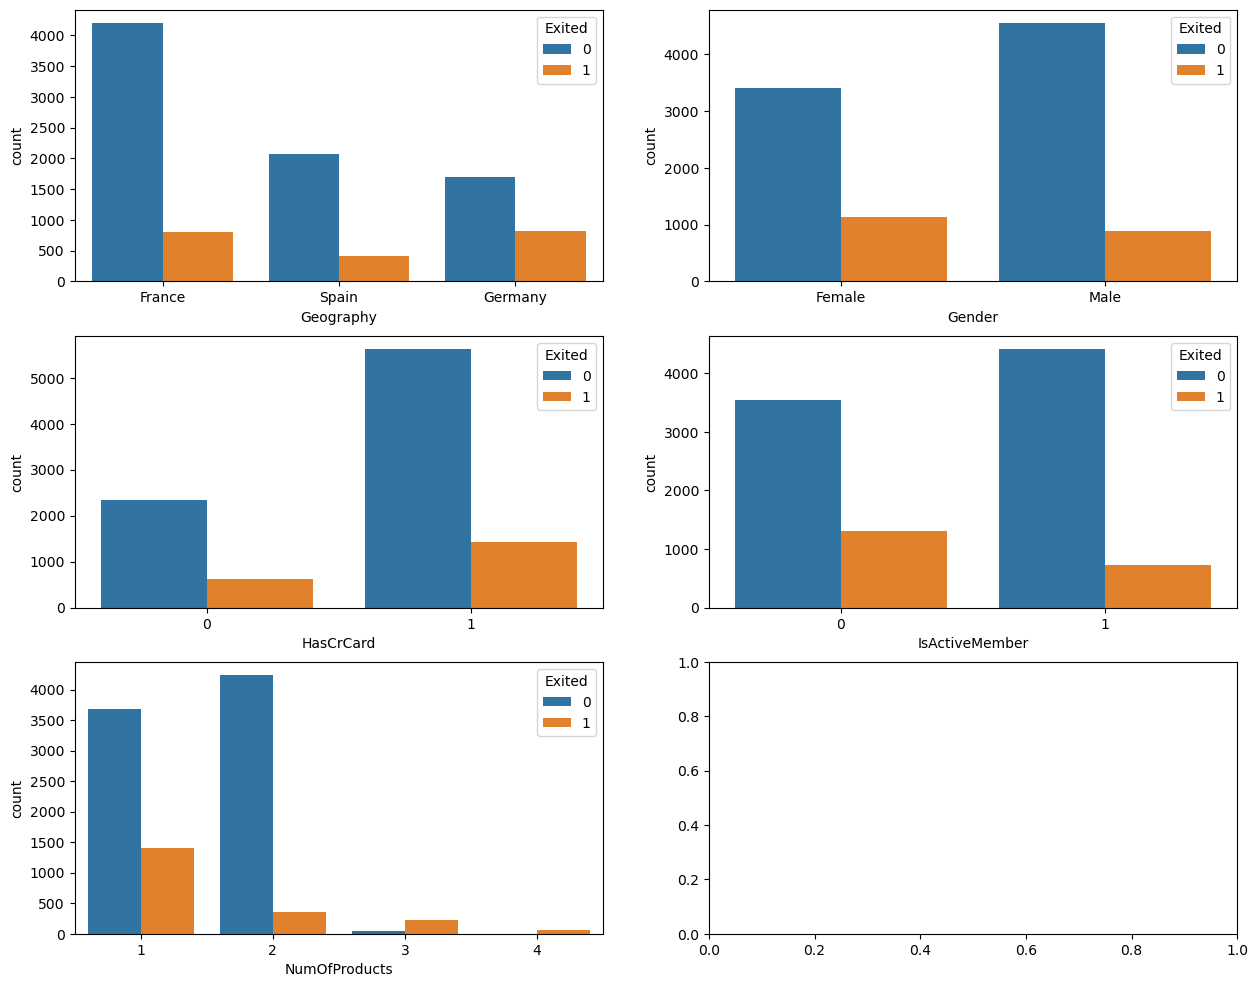

In [ ]:
fig, axarr = plt.subplots(3, 2, figsize=(15, 12))
sns.countplot(x='Geography', hue = 'Exited',data = df, ax=axarr[0][0])
sns.countplot(x='Gender', hue = 'Exited',data = df, ax=axarr[0][1])
sns.countplot(x='HasCrCard', hue = 'Exited',data = df, ax=axarr[1][0])
sns.countplot(x='IsActiveMember', hue = 'Exited',data = df, ax=axarr[1][1])
sns.countplot(x='NumOfProducts', hue = 'Exited',data = df, ax=axarr[2][0])

Observações intrigantes podem ser percebidas após a primeira visualização de dados, como:
- Os clientes alemães estão apresentando maior churn, mesmo tendo a menor quantidade de clientes entre os países, o que pode ser um indício de que a qualidade do serviço prestado na Alemanha pode estar aquém, caso comparada ao padrão encontrado na França e na Espanha.
- Clientes mulheres estão demonstrando mais susceptibilidade ao churn, ponto que vale uma investigação mais profunda.
- O fato do cliente não estar ativo também demonstra ser um bom preditor para a ocorrência do churn.
- Clientes que possuem um terceiro ou quarto produto com o banco apresentam taxa de churn muito maior que os clientes com menos produtos, o que é um comportamento diferente do disseminado no mercado em geral, de que a fidelização do cliente vem com uma maior quantidade de produtos utilizados. Caso não exista erro no input dos dados, precisamos entender quando esses produtos estão sendo oferecidos (hipótese 1: é no final das negociações de fechamento de conta) e se são realmente úteis para o cliente (hipótese 2: produtos são de baixa qualidade, tem serviço ruim ou são pouco necessários).

<AxesSubplot:xlabel='Exited', ylabel='EstimatedSalary'>

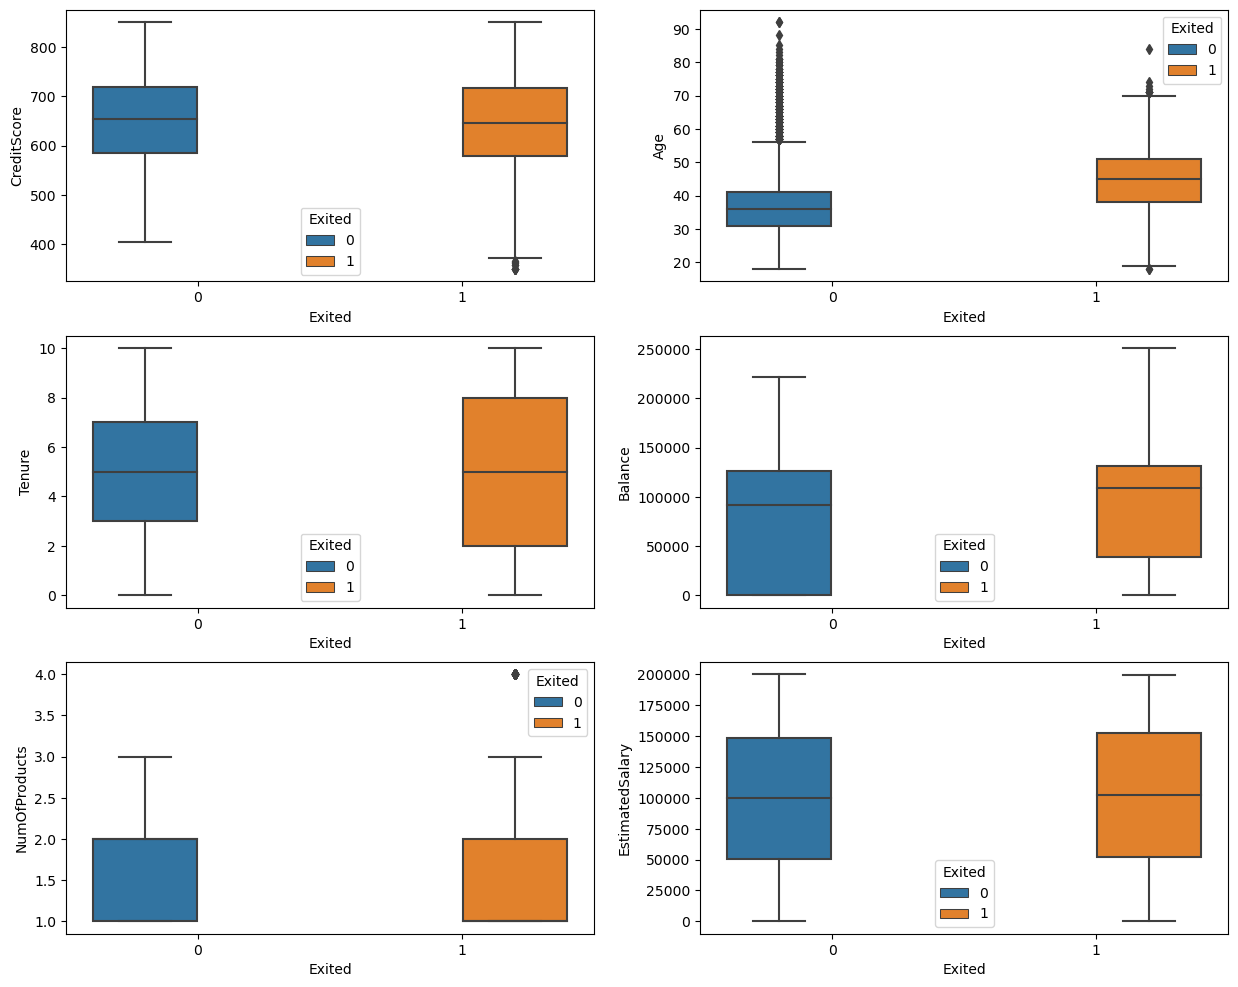

In [ ]:
    # Relations based on the continuous data attributes
fig, axarr = plt.subplots(3, 2, figsize=(15, 12))
sns.boxplot(y='CreditScore',x = 'Exited', hue = 'Exited',data = df, ax=axarr[0][0])
sns.boxplot(y='Age',x = 'Exited', hue = 'Exited',data = df , ax=axarr[0][1])
sns.boxplot(y='Tenure',x = 'Exited', hue = 'Exited',data = df, ax=axarr[1][0])
sns.boxplot(y='Balance',x = 'Exited', hue = 'Exited',data = df, ax=axarr[1][1])
sns.boxplot(y='NumOfProducts',x = 'Exited', hue = 'Exited',data = df, ax=axarr[2][0])
sns.boxplot(y='EstimatedSalary',x = 'Exited', hue = 'Exited',data = df, ax=axarr[2][1])

Visualizações como boxplots e countplots foram fundamentais para entender as distribuições de características-chave entre os clientes que permaneceram e os que saíram. Por exemplo, embora o escore de crédito não pareça ser um fator distintivo entre os dois grupos, o saldo dos clientes em churn é ligeiramente maior, indicando uma possível falha em reter os clientes mais abastados.

In [ ]:
df.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

### Modelagem

In [ ]:
X = df.drop(columns = ["Exited"], axis = 1)
y = df["Exited"]

In [ ]:
# Separando em variáveis numéricas e categóricas
numerical_features = df.nunique()[df.nunique() > 5].index
categorical_features = df.nunique()[df.nunique() <= 5].index[:-1]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [ ]:
# Copiando os datasets originais
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

In [ ]:
# Separando em variáveis categóricas binárias e não binárias
categorical_features_binary = X.nunique()[X.nunique() == 2].index
categorical_features_non_binary = X.nunique()[(X.nunique() > 2) & (X.nunique() <= 5)].index

In [ ]:
# Criando um transformador para preencher valores faltantes
missing_transformer = ColumnTransformer([
    ('num_missing', SimpleImputer(strategy = 'median'), numerical_features),
    ('cat_missing', SimpleImputer(strategy = 'most_frequent'), categorical_features)
])

In [ ]:
# Criando um transformador para codificar variáveis categóricas
cat_transformer = ColumnTransformer([
    ('cat_binary', OneHotEncoder(drop = 'first'), categorical_features_binary),
    ('cat_non_binary', ce.TargetEncoder(), categorical_features_non_binary)
])

In [ ]:
X.index

RangeIndex(start=0, stop=10000, step=1)

In [ ]:
# Uso da função preprocessor
scaler = MinMaxScaler()
X_train, X_test = preprocessor(X_train, y_train, X_test, scaler)

Para abordar a tarefa de previsão de churn, implementamos diversos modelos de machine learning, como RandomForest, GradientBoosting, DecisionTree, XGBoost, LGBM e CatBoost. Utilizamos validação cruzada para avaliar o desempenho dos modelos, focando em métricas como ROC AUC, Precisão Média, Precisão, Recall e F1-Score. Essa abordagem proporciona uma visão abrangente da capacidade preditiva dos modelos.

#### XGBOOST

In [ ]:
# Criação do modelo
xgb = XGBClassifier(n_estimators = 1000, max_depth = 5, random_state = 0, scale_pos_weight = 3.909)
# Avaliação do desempenho
modelo(xgb, X_train, y_train, X_test, y_test)

Score Cross Validation: 82.07%
Average Precision: 42.78%
Precision Score: 59.31%
Recall Score: 57.56%
F1 Score: 58.42%
ROC AUC Score: 73.73%


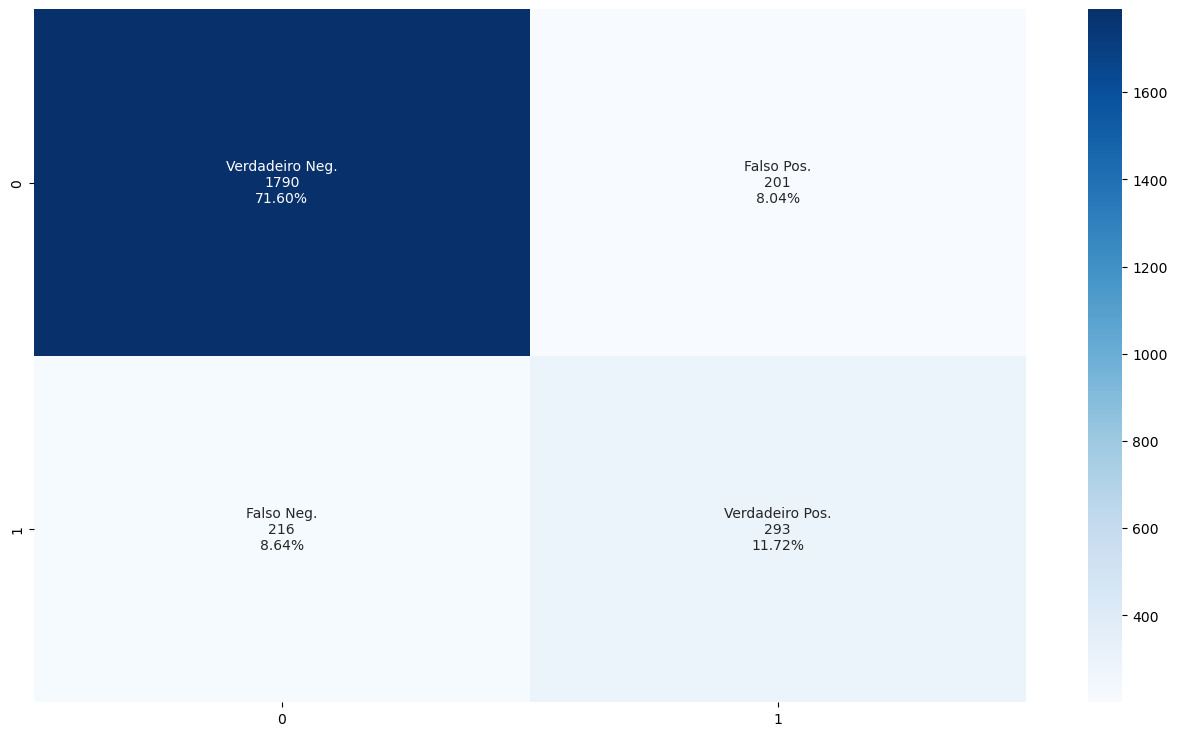

In [ ]:
# Vendo a matriz de confusão
matriz_confusao(xgb, X_test, y_test)

#### LIGHTGBM

In [ ]:
lgbm = LGBMClassifier(n_estimators = 1000, max_depth = 5, random_state = 0, scale_pos_weight = 2.77)

In [ ]:
# Avaliação do desempenho
modelo(lgbm, X_train, y_train, X_test, y_test)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 1528, number of negative: 5972
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004645 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 853
[LightGBM] [Info] Number of data points in the train set: 7500, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203733 -> initscore=-1.363122
[LightGBM] [Info] Start training from score -1.363122
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


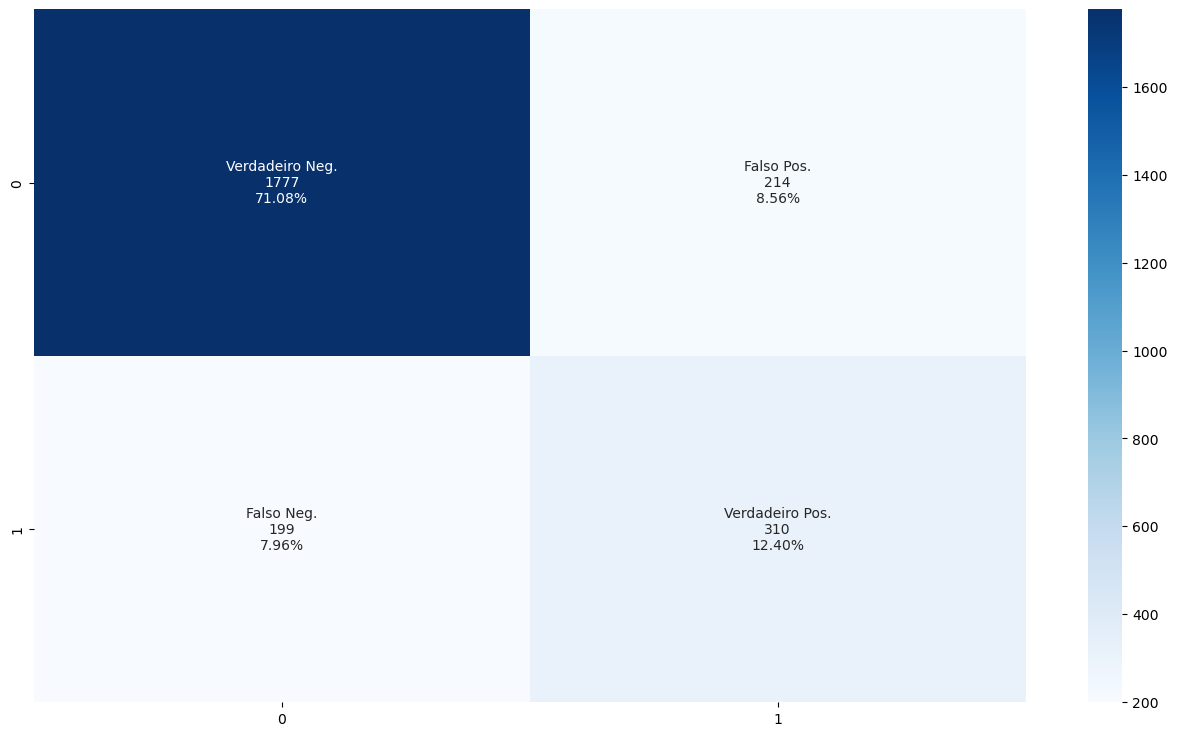

In [ ]:
# Vendo a matriz de confusão
matriz_confusao(lgbm, X_test, y_test)

#### CATBOOST CLASSIFIER

In [ ]:
cbc = CatBoostClassifier(n_estimators = 1000, max_depth = 5, random_state = 0, class_weights = {0: 1, 1: 2.77}, verbose = False)

In [ ]:
# Avaliação do desempenho
modelo(cbc, X_train, y_train, X_test, y_test)

Score Cross Validation: 85.88%
Average Precision: 46.00%
Precision Score: 56.71%
Recall Score: 70.53%
F1 Score: 62.87%
ROC AUC Score: 78.38%


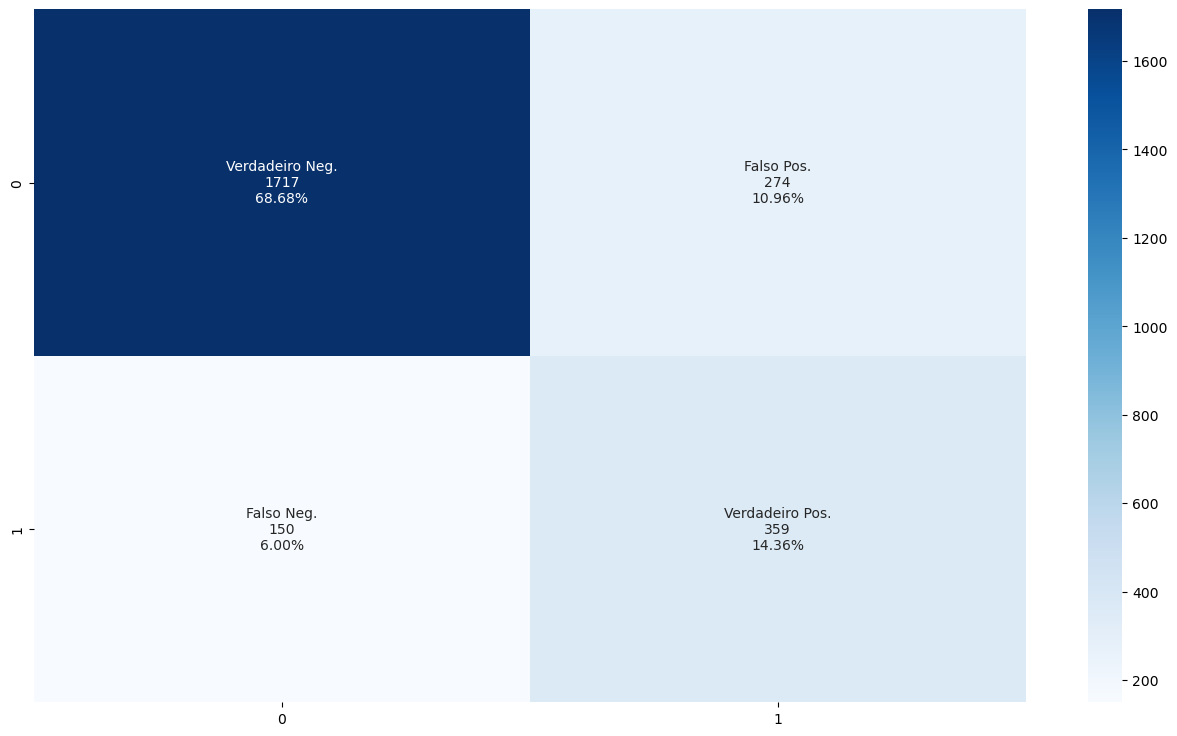

In [ ]:
# Vendo a matriz de confusão
matriz_confusao(cbc, X_test, y_test)

#### RANDOM FOREST

In [ ]:
rfc = RandomForestClassifier(n_estimators = 1000, max_depth = 7, random_state = 0, n_jobs = -1, class_weight = 'balanced')

In [ ]:
# Avaliação do desempenho
modelo(rfc, X_train, y_train, X_test, y_test)

Score Cross Validation: 85.81%
Average Precision: 42.25%
Precision Score: 49.30%
Recall Score: 75.64%
F1 Score: 59.69%
ROC AUC Score: 77.87%


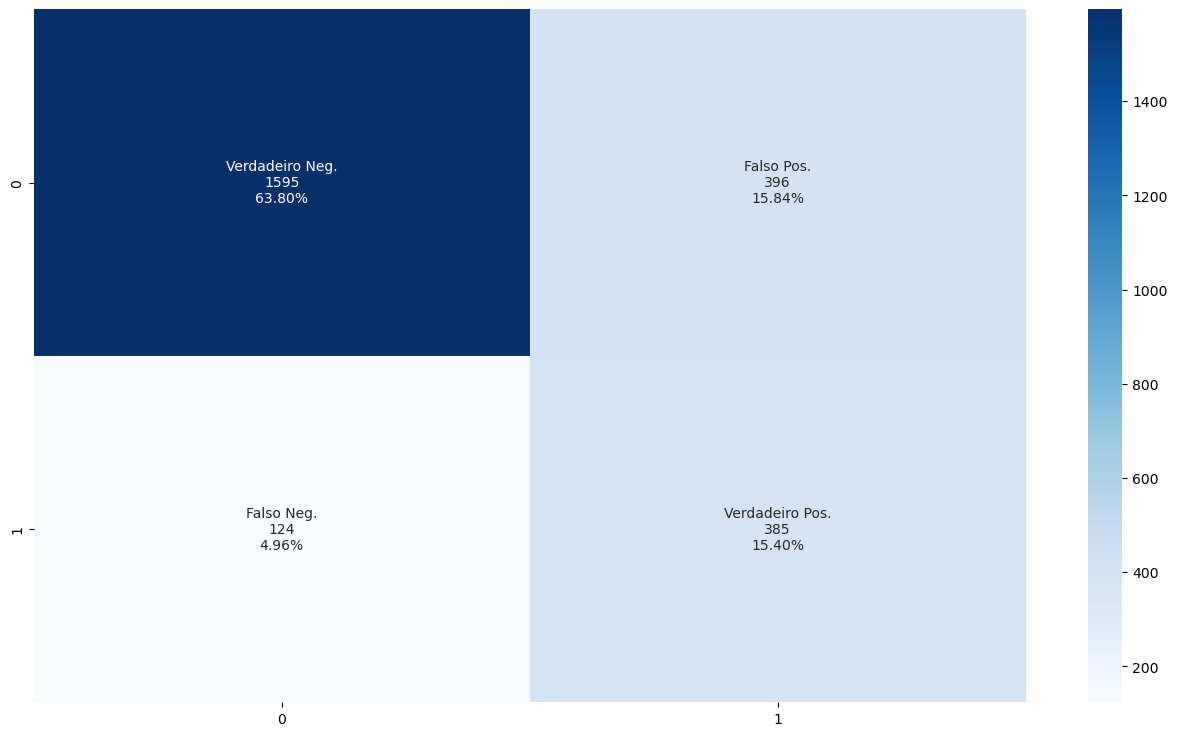

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [ ]:
# Vendo a matriz de confusão
matriz_confusao(rfc, X_test, y_test)

Devido a caracteristica desbalanceada dos dados, utilizaremos a Revocação(Recall) como métrica de avaliação. No caso, o modelo que apresentou o melhor resultado foi o de Random Forest, onde tivemos um número baixo de falsos negativos. Conseguimos identificar o churn em 75% dos casos.